## 1.引言

上一节[从零预训练模型](https://golfxiao.blog.csdn.net/article/details/144378527)介绍了对模型进行预训练的基本实现步骤，但这个版本是比较原始的，代码有些散，训练速度比较慢。本节我们将会尝试对这个预训练步骤进行工程化改造，并尝试引入一些优化技术来提高模型训练的效率和稳定性。

其实，我们上上一节[高效数据加载器](https://golfxiao.blog.csdn.net/article/details/144202191)所介绍的`np.memmap`就是一种训练优化技术，它首先一次性预序列化了所有语料数据，并通过内存-磁盘映射技术实现了数据加载速度的近300倍提升。本文我们会再介绍几种从不同层面来加速和稳定预训练过程的技术，有以下几项：
- 混合精度训练，从数据和参数精度层面来优化； 
- 学习率调度，从稳定训练过程层面来优化；
- FlashAttention，从加速计算层面来优化； 

在介绍这几个技术之前，我们会先封装一个训练器，对前面已经介绍的模型训练基本流程进行封装，以便代码复用并简化使用难度。

## 2.封装训练器
先引入以前封装过的模型结构和数据集加载实现。

In [1]:
%reload_ext autoreload  
%autoreload 2 
%run transformer.py
%run pretrain_dataset.py
from torch.nn.parallel import DistributedDataParallel

编写一个训练器类，之前的预训练过程拆分为以下方法环节：
- 训练器和训练参数初始化
- set_loader: 设置数据加载器
- set_seed: 设置随机数种子
- train_step: 单步训练，负责一个小批量数据训练
- evaluate: 评估验证，用于在训练期间验证模型损失是否下降
- train_epoch: 单轮数据集训练
- train: 训练主流程：训练对外入口
- save_model: 训练状态保存
- load_from_checkpoint: 训练状态恢复
- predict: 模型推理

In [11]:
import time
import torch.nn.functional as f
from torch.nn.parallel import DistributedDataParallel

class Trainer:
    def __init__(self, model, optimizer, train_args:dict, device='cpu', verbose=False):
        self.cur_time = lambda: time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(time.time()))
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.verbose = verbose
        self.target_lr = float(optimizer.defaults['lr'])
        self.num_epochs = train_args.get("num_train_epochs", 0)
        self.batch_size = train_args.get("train_batch_size", 8)
        self.eval_steps = train_args.get("eval_steps", 1000)
        self.save_steps = train_args.get("save_steps", 1000)
        self.warmup_steps = train_args.get("warmup_steps", 1000)
        self.output_dir = train_args.get("output_dir")
        self.last_checkpoint_path = train_args.get("last_checkpoint_path")
        self.train_loader = None
        self.eval_loader = None
        self.steps_per_epoch = 0   # 每个epoch的训练步骤数
        self.step = 0              # 正在训练的step编号
        self.total_steps = 0       # 总的步骤数
        self.train_loss_acc = 0    # 训练损失累计

    def set_loader(self, train_loader, eval_loader):
        self.train_loader = train_loader
        self.eval_loader = eval_loader
        self.steps_per_epoch = len(train_loader)
        self.total_steps = self.num_epochs * self.steps_per_epoch
        print(f'set train_loader steps: {len(train_loader)}, eval_loader: {len(eval_loader)}') if self.verbose else None

    def set_seed(self, seed):
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False  
        print(f"set seed to {seed}") if self.verbose else None
        
    def train_step(self, X, Y):
        self.model.train()
        self.optimizer.zero_grad()
        logits = self.model(X)
        loss = f.cross_entropy(logits.flatten(0, 1), Y.flatten())
        loss.backward()
        self.optimizer.step()
        return loss

    def evaluate(self):
        self.model.eval()
        num_batches = len(self.eval_loader)
        total_loss = 0
        for (X, Y) in self.eval_loader:
            with torch.no_grad():
                logits = self.model(X.to(self.device))
            loss = f.cross_entropy(logits.flatten(0, 1), Y.to(self.device).flatten())
            total_loss += loss.item()
        self.model.train()
        return total_loss/num_batches  

    def train_epoch(self, epoch):
        assert self.train_loader and self.eval_loader, f"train_loader and eval_loader can't be empty."
        
        for i, (X, Y) in enumerate(self.train_loader):     
            loss = self.train_step(X.to(self.device), Y.to(self.device))
            self.train_loss_acc += loss.item()
            self.step += 1
    
            if self.step % self.eval_steps == 0:
                train_loss = self.train_loss_acc/self.eval_steps
                eval_loss = self.evaluate()
                print(f"{self.cur_time()} train_loss: {train_loss:.4f}, eval_loss: {eval_loss:.4f}, "
                    + f"step: {self.step}/{self.total_steps}")
                self.train_loss_acc = 0

    def train(self):
        self.model.to(self.device)
        for epoch in range(self.num_epochs):
            self.train_epoch(epoch)
        
    
    def save_model(self, checkpoint_path, epoch):
        local_model, optimizer, step = self.model, self.optimizer, self.step
        os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
        torch.save({
            "model_state": local_model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "epoch": epoch,
            "step": step,
        }, checkpoint_path)

    def load_from_checkpoint(self, checkpoint_path):
        local_model, optimizer, device = self.model, self.optimizer, self.device
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        local_model.load_state_dict(checkpoint['model_state'])
        if optimizer != None:
            optimizer.load_state_dict(checkpoint['optimizer_state'])

        self.step = checkpoint.get('step', 0)
        return checkpoint.get('epoch', 0), 
   
    def predict(self, tokenizer, input_text, max_length=100):
        inputs = torch.tensor([tokenizer.encode(input_text)]).to(self.device)
        response_ids = self.model.generate(inputs, max_length=max_length, eos_token_id=tokenizer.eos_token_id, use_kv_cache=False)
        return tokenizer.decode(response_ids.squeeze(0))

先封装一个数据加载器的快速构建方法，它会完成数据集加载、训练集和验证集的切割以及小批量数据加载器的创建，这个方法可以给我们快速验证优化技术的效果提供帮助。

In [3]:
def build_train_eval_loader(dataset_path, data_len=0, batch_size=4, train_ratio=0.9, context_length=1024):
    ds = PretrainBinaryDataset(dataset_path, context_length)
    if data_len > 0:
        ds = Subset(ds, range(data_len))
    return create_dataloaders(ds, batch_size=batch_size, train_ratio=train_ratio)

## 3.混合精度训练

#### 3.1 什么是混合精度训练？

可以通俗解释为：16位是一种数据精度，32位是另一种数据精度，如果在模型训练时混合使用16位和32位就可以称之为混合精度训练。

训练过程中的混合精度具体体现在：
- 模型参数：模型的权重可以存储为 16 位浮点数，以减少内存占用。
- 前向传播：在前向传播和损失计算过程中，计算使用 16 位浮点数，以加速计算。
- 累积梯度和优化器：关键的累积梯度和优化器状态变量仍然使用 32 位浮点数，以保持数值稳定性和训练精度。
> 这个优化思想就好比在做饭的时候，有些成分用精确的量杯（32 位浮点数）来测量，有些成分用粗糙的量杯（16 位浮点数）来测量。这样，你不仅能够节省时间，还能减少厨房的杂乱，但最终做出来的饭菜依然美味可口（保持模型的训练精度）。

#### 3.2 代码实现
混合精度训练主要是对单步训练的逻辑进行调整，我们需要编写一个新的单步训练构建函数，代码实现如下所示。

In [15]:
from contextlib import nullcontext

def train_step_with_scaler(self, X, Y): 
    enable_mixed_precision = X.device.type == "cuda" and self.scaler is not None
    ctx = (torch.amp.autocast('cuda') if enable_mixed_precision else nullcontext())  
    
    self.optimizer.zero_grad(set_to_none=True)  
    with ctx:  
        logits = self.model(X)  
        loss = f.cross_entropy(logits.flatten(0, 1), Y.flatten())

    if enable_mixed_precision:  # 检查是否使用混合精度  
        self.scaler.scale(loss).backward()  
        self.scaler.unscale_(self.optimizer)  
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)  
        self.scaler.step(self.optimizer)  
        self.scaler.update()  
    else:  
        loss.backward()  # 普通精度的反向传播  
        self.optimizer.step()  # 更新参数  

    return loss 

setattr(Trainer, "train_step", train_step_with_scaler)

这个支持混合精度的单步训练函数，相比之前主要做了以下几个关键改造：
1. 使用autocast进行自动精度转换，在`with ctx`的上下文范围，会自动将模型参数和数据由32位转换为float16进行运算，这将有效减少前向传播过程中的内存占用和时间消耗； 
2. 使用GradScaler进行梯度缩放，目的是防止半精度浮点数(fp16)在进行训练时，出现数值下溢和上溢； 
3. 使用`clip_grad_norm_`方法进行梯度剪裁，防止梯度爆炸。梯度剪裁的最大范数为1.0，如果梯度的范数超过这个值，将其缩放到这个范围内。

为了支持在前面构建的训练器上启用混合精度训练，我们需要配套添加一个开关方法，当启用混合精度训练时，则创建一个梯度缩放器。

In [16]:
def set_grad_scaler(self, enabled=True):
    if enabled:
        self.scaler = torch.amp.GradScaler('cuda', enabled=True)
    else:
        self.scaler = None
    print("grad scaler enabled: ", enabled)
    
setattr(Trainer, "set_grad_scaler", set_grad_scaler)

#### 3.3 效果测试

将创建训练器的步骤封装为一个函数，方便调用。

In [6]:
def build_trainer(train_loader, eval_loader, device='cpu', use_mixed_precision=False, seed=123, verbose=True):
    model = MiniGPT(GPTConfig())
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
    trainer = Trainer(model, optimizer, device, verbose=verbose)
    trainer.set_seed(seed)
    trainer.set_grad_scaler(use_mixed_precision)
    trainer.set_loader(train_loader, eval_loader)
    return trainer

我们使用一个大小为1000条，batch_size=4的小数据集，先在`cuda:0`设备上测试下不启用混合精度时的训练表现。

In [7]:
train_args = {
    "num_epochs": 1,
    "eval_steps": 25,
}
train_loader, eval_loader = build_train_eval_loader(dataset_path, data_len=1000, batch_size=4)
trainer_fp32 = build_trainer(train_loader, eval_loader, device='cuda:0')
start_time = time.time()
trainer_fp32.train(train_args)
print(f"Training time without mixed precision: {time.time()-start_time:.2f} seconds") 

total_tokens: 8350205240
set seed to 123
enable mixed precision:  False
set train_loader steps: 225, eval_loader: 25
start epoch:  1
2024-12-22 08:52:33 cuda:0, train_loss: 8.6199, eval_loss: 8.1318, steps: 25/225
2024-12-22 08:52:43 cuda:0, train_loss: 8.0786, eval_loss: 8.0123, steps: 50/225
2024-12-22 08:52:52 cuda:0, train_loss: 7.9294, eval_loss: 7.8604, steps: 75/225
2024-12-22 08:53:01 cuda:0, train_loss: 7.8207, eval_loss: 7.8047, steps: 100/225
2024-12-22 08:53:11 cuda:0, train_loss: 7.8003, eval_loss: 7.7552, steps: 125/225
2024-12-22 08:53:20 cuda:0, train_loss: 7.7164, eval_loss: 7.7117, steps: 150/225
2024-12-22 08:53:30 cuda:0, train_loss: 7.7399, eval_loss: 7.7137, steps: 175/225
2024-12-22 08:53:39 cuda:0, train_loss: 7.7183, eval_loss: 7.6712, steps: 200/225
2024-12-22 08:53:48 cuda:0, train_loss: 7.6642, eval_loss: 7.6418, steps: 225/225
Training time without mixed precision: 84.96 seconds


再用测试下启用混合精度时的训练表现，为避免OOM，我们换另一张卡`cuda:1`。

In [11]:
train_loader, eval_loader = build_train_eval_loader(dataset_path, data_len=1000, batch_size=4)
trainer_fp16 = build_trainer(train_loader, eval_loader, use_mixed_precision=True, device='cuda:1')
start_time = time.time()
trainer_fp16.train(train_args)
print(f"Training time with mixed precision: {time.time()-start_time:.2f} seconds") 

total_tokens: 8350205240
set seed to 123
enable mixed precision:  True
set train_loader steps: 225, eval_loader: 25
start epoch:  1


/tmp/ipykernel_28979/3681912438.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  ctx = (torch.cuda.amp.autocast() if (X.device.type == "cuda" and use_mixed_precision) else nullcontext())


2024-12-22 09:01:30 cuda:1, train_loss: 8.5759, eval_loss: 8.1008, steps: 25/225
2024-12-22 09:01:36 cuda:1, train_loss: 8.0254, eval_loss: 7.9560, steps: 50/225
2024-12-22 09:01:43 cuda:1, train_loss: 7.9008, eval_loss: 7.8768, steps: 75/225
2024-12-22 09:01:50 cuda:1, train_loss: 7.8282, eval_loss: 7.8138, steps: 100/225
2024-12-22 09:01:56 cuda:1, train_loss: 7.7657, eval_loss: 7.7565, steps: 125/225
2024-12-22 09:02:03 cuda:1, train_loss: 7.7587, eval_loss: 7.7309, steps: 150/225
2024-12-22 09:02:09 cuda:1, train_loss: 7.7441, eval_loss: 7.6973, steps: 175/225
2024-12-22 09:02:16 cuda:1, train_loss: 7.6565, eval_loss: 7.6358, steps: 200/225
2024-12-22 09:02:23 cuda:1, train_loss: 7.6036, eval_loss: 7.5917, steps: 225/225
Training time with mixed precision: 59.37 seconds


通过对比可以发现，同样的任务不使用混合精度时训练需要84.96s,而使用混合精度后训练只需要59.37s, 训练速度提升约30%。

不仅如此，在内存方面，不使用混合精度时训练至少需要12.9GB内存（cuda:0)，而启用混合精度后训练只占用10.18GB内存(cuda:1)，内存占用减少21%（如下图所示）。
![混合精度训练内存占用对比](./img/mixed_precision_memory.jpg)

## 4.FlashAttention

#### 4.1 什么是FlashAttention?
简单来说，FlashAttention是用来加速attention计算的，因为attention计算是比较慢的，至少还有优化空间。那attention计算为什么慢呢？

我们知道，Attention是一个注意力机制，它用来决定输入序列中哪些部分对于当前输出是最重要的。但在计算时，它依赖两个大矩阵`Q`和`K的转置`进行乘法运算，计算复杂度和序列长度`seq_len`的平方成正比，即 $O(seq\_len^2)$，这意味着序列长度增加10倍，计算时间将会增加100倍，这在处理长序列时会变得非常耗时。

不仅是时间，Attention计算在空间占用复杂度上也和序列长度的平方成正比，序列越长，显存占用越高。

FlashAttention就是通过减少时间复杂度和空间复杂度两个角度来加速计算，它与原来的Attention相比，有以下三个特点：
- 运算速度更快 (Fast)；
- 更节省显存 (Memory-Efficient)；
- 计算结果相同 (Exact)。

**FlashAttention的基本思想**：不直接对整个输入序列计算注意力，而是将其分为多个较小的块，逐个对这些块进行计算，通过维护一些中间变量来增量式地进行softmax 归一化，这样就不需要一次性计算整个注意力权重矩阵。

#### 4.2 代码实现
下面是一个用FlashAttention改造后的多头自注意力实现，前面的部分基本相同，最主要改动是将注意力分数、注意力权重、上下文向量的计算用flash_attn_func来替代。


In [6]:
from flash_attn import flash_attn_func

class FlashMultiHeadAttention(MultiHeadAttention):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def forward(self, x, pos_cis=None):
        # 输入形状
        b, num_tokens, dim_in = x.shape

        # 求Q\K\V矩阵，形状变为： b, num_tokens, dim_out
        q, k, v = self.Wq(x), self.Wk(x), self.Wv(x)

        # 变换形状，将最后一维拆成多头，每个头有head_dim维，矩阵形状由三维变为四维。
        q = q.view(b, num_tokens, self.num_heads, self.head_dim)
        k = k.view(b, num_tokens, self.num_heads, self.head_dim)
        v = v.view(b, num_tokens, self.num_heads, self.head_dim)

        q, k = apply_rotary_emb(q, k, pos_cis) if pos_cis else q, k
        
        # 交换第2维和第3维，这一步过后，形状变为：b, num_heads, num_tokens, head_dim
        q = q.transpose(1, 2)   
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # 检查数据精度，FlashAttention要求参数采用16位精度
        input_dtype = q.dtype
        if input_dtype == torch.float32:
            if torch.is_autocast_enabled():
                target_dtype = torch.get_autocast_gpu_dtype()
            else:
                target_dtype = torch.float16
            q = q.to(dtype=target_dtype)
            k = k.to(dtype=target_dtype)
            v = v.to(dtype=target_dtype)

        # 重点：采用FlashAttention进行自注意力计算加速，dropout只有在训练模式下才送入flash_attn
        dropout_rate = self.dropout.p if self.training else 0.0
        context_vecs = flash_attn_func(q, k, v, dropout_p=dropout_rate, softmax_scale=self.head_dim ** -0.5, causal=True)
        context_vecs = context_vecs.to(dtype=input_dtype)
        
        # （下面这一部分与之前相同）
        context_vecs = context_vecs.transpose(1,2)  # shape: b, num_tokens, num_heads, head_dim
        context_vecs = context_vecs.contiguous().view(b, num_tokens, self.dim_out)
        output = self.Wo(context_vecs)

        return output

> 从上面的实现可以看出来，FlashAttention只是对注意力机制的计算过程进行了优化，整个MultiAttention的结构并没有变化，甚至其主要计算步骤都没有变化（如Q、K、V矩阵的加权求和），因此可以直接替换原有的Attention实现，并且能够复用已经训练的参数。

#### 4.3 效果测试

下面我们来验证下引入FlashAttention后的效果。首先，创建一个批次为8、长度1024、嵌入维度为768的随机张量`x`作为输入。 

In [10]:
batch_size, seq_len, dim = 8, 1024, 768
iter_nums=1000
device = 'cuda:0'
dtype = torch.float16
x = torch.randn(batch_size, seq_len, dim, dtype=dtype) 
print("input shape:", x.shape)

input shape: torch.Size([8, 1024, 768])


定义一个函数，用于对模型进行前向推理，并计算耗时。

In [14]:
import time

def time_forward(model, x, pos_cis=None, n=1, device='cpu'):
    model.to(device)
    x = x.to(device)
    start_time = time.time()
    with torch.no_grad():  
        [model(x, pos_cis) for _ in range(n)]
    return time.time() - start_time

对上面的批量序列进行1000次推理，比较是否使用flashAttention的速度差异

In [15]:
model_no_flash = MultiHeadAttention(dim, dim, seq_len, 0.1, num_heads=12).to(dtype)
no_flash_time = time_forward(model_no_flash, x, n=iter_nums, device=device)
print(f"without FlashAttention: time_total={no_flash_time * 1000:.2f} ms, time_average={no_flash_time * 1000/iter_nums:.2f} ms") 

without FlashAttention: time_total=3419.17 ms, time_average=3.42 ms


In [16]:
model_with_flash = FlashMultiHeadAttention(dim, dim, seq_len, 0.1, num_heads=12).to(dtype)
with_flash_time = time_forward(model_with_flash, x, n=iter_nums, device=device)
print(f"Time with FlashAttention: {with_flash_time * 1000:.2f} ms, average={with_flash_time * 1000/iter_nums:.2f} ms") 

Time with FlashAttention: 776.24 ms, average=0.78 ms


从上面测试来看，`使用flashAttention`和`不使用flashAttention`的前向传播速度`相差4倍`以上。这一显著的性能提升表明，FlashAttention 在处理大规模 Transformer 模型时能够有效减少计算时间，使得训练和推理过程更加高效。

#### 4.4 集成到模型
我们需要将这个`FlashMultiHeadAttention`组件添加到MiniGPT的模型结构中，后续的训练才能使用它，具体有以下三步（这里只做下示意）。
1. 将FlashMultiHeadAttention的代码实现拷贝到attention_v1.py中（自行添加）；
2. 改造TransformerBlock，以支持通过一个模型配置项`flash_attn`来决定是否启用FlashAttention； 

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        attn_kwargs = {  
            'dim_in': kwargs['emb_dim'],  
            'dim_out': kwargs['emb_dim'],  
            'context_length': kwargs['context_length'],  
            'num_heads': kwargs['n_heads'],  
            'dropout_rate': kwargs['drop_rate'],  
            'qkv_bias': kwargs['qkv_bias']  
        }  
        if kwargs.get('flash_attn'):
            self.atten = FlashMultiHeadAttention(**attn_kwargs)
            print("use flash attention.")
        else:
            self.atten = MultiHeadAttention(**attn_kwargs)
        self.ffn = FeedForward(kwargs['emb_dim'])
        ……

3. 在模型配置项中支持`flash_attn`选项； 

In [ ]:
class GPTConfig(PretrainedConfig):
    model_type = "minigpt"

    def __init__(self, **kwargs):
        self.context_length = kwargs.get('context_length', 1024)
        ……
        self.flash_attn = kwargs.get('flash_attn', False)
        super().__init__(**kwargs)

## 5.学习率调度

学习率是训练过程中影响模型学习效果的重要超参数之一，过大的学习率容易引起梯度下降的不稳定而导致模型无法收敛，太小的学习率则会导致训练过程非常缓慢。

所以，在实际训练过程中，我们都会采用一些学习率调度的策略，最常用的就是**余弦退火算法**，下面我们用一个函数来实现它。

In [17]:
import math

def get_dynamic_lr(target_lr, cur_step, warmup_steps, decay_steps):
    min_lr = target_lr/10
    if cur_step < warmup_steps:
        return target_lr * (cur_step / warmup_steps)
    if cur_step > decay_steps:
        return min_lr
    
    step_ratio = (cur_step - warmup_steps)/(decay_steps-warmup_steps)
    cos_scope = 0.5 * (1 + math.cos(math.pi * step_ratio))
    return min_lr + (target_lr - min_lr) * cos_scope

setattr(Trainer, "get_dynamic_lr", staticmethod(get_dynamic_lr))

按照上面这个学习率调度算法，可以将学习率的变化分为三个阶段：预热、退火和衰减结束。

1. **预热**：如果当前迭代次数小于预热迭代次数`warmup_steps`，则学习率线性增加，从`0`到`target_lr`。
> 预热算法的理论依据在于：神经网络在刚开始训练时，参数更新方向并非如同理想情况一样那么确定。模型参数在初始化时，是非常不稳定的，因此在刚开始时需要选用小的学习率，然后逐渐增大到预设的学习率，这个过程称为模型训练的`热身`。

2. **退火**：热身完后，就开始用较高的学习率训练模型。随着训练的进行，模型的损失会逐渐接近低谷，此时高学习率就会使得权重的梯度来回震荡，很难使训练的损失值达到全局最低谷，所以训练中后期需要通过余弦函数来降低学习率。余弦函数的特性在于先缓慢下降，然后加速下降，再次缓慢下降。
> 函数的关键参数和步骤解读：
> - step_ratio为当前迭代次数相对于学习率衰减阶段的比例，范围在0-1之间； 
> - math.cos(math.pi * decay_ratio)的值在-1到1之间，为了将其调整到0-1之间就加1乘以0.5； 
> - 由于余弦是从1到0梯减的，所以最终的余弦系数cos_scope就是从1到0递减，相应的`min_lr + cos_scope * (target_lr - min_lr)`计算出的学习率也是从lr到min_lr递减； 

3. **衰减结束**：如果当前迭代次数大于衰减迭代次数`decay_steps`，则学习率为最小值`min_lr`（一般定义为目标学习率的1/10），后续模型将以这个最小学习率训练下去。

下面我们给定一组参数，用这个调度函数实际计算一组学习率数据，并存放到`learning_rates`列表中。

In [24]:
# 参数设置  
target_lr = 0.001  # 目标学习率  
warmup_steps = 100  # 热身步骤数  
decay_steps = 1000  # 衰减截止步骤  
total_steps = 1500  # 总训练步骤数

# 生成学习率数据  
learning_rates = []  
for step in range(total_steps + 1):  
    lr = get_lr(target_lr, step, warmup_steps, decay_steps)  
    learning_rates.append(lr)  

为了更加直观的查看这组学习率数据是否如预期一样被调度，我们用matplotlib库来绘制这组学习率数据`learning_rates`的实际变化曲线。

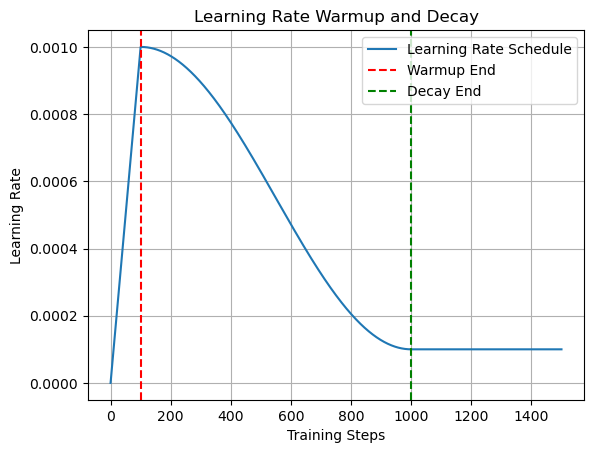

In [26]:
import matplotlib.pyplot as plt
 
plt.plot(range(total_steps + 1), learning_rates, label='Learning Rate Schedule')  
plt.title('Learning Rate Warmup and Decay')  
plt.xlabel('Training Steps')  
plt.ylabel('Learning Rate')  
plt.axvline(x=warmup_steps, color='red', linestyle='--', label='Warmup End')  
plt.axvline(x=decay_steps, color='green', linestyle='--', label='Decay End')  
plt.legend()  
plt.grid()  
plt.show()  

在上面图中，红色竖线之前为预热阶段，绿色竖线之后表示衰减结束。红色竖线与绿色竖线之间为退火阶段（由于这段曲线很像余弦函数的右半部分，所以常被称为余弦退火）。

下面我们再添加一个``函数，将基于``计算得到的学习率来动态更新到优化器中。

In [18]:
def adjust_lr(self):
    lr = self.get_dynamic_lr(self.target_lr, self.step, self.warmup_steps, self.total_steps )
    if lr <= 0: return self.target_lr
    for param_group in self.optimizer.param_groups:
        param_group['lr'] = lr
    return lr

setattr(Trainer, "adjust_lr", adjust_lr)

## 6 整体效果验证

上面引入了三个优化组件：混合精度训练、FlashAttention和学习率调度，这一部分我们来验证下这三个组件引入后的效果。

首先编写一个main函数，用于启动模型训练，它主要完成如下职责：
1. 设置训练参数； 
2. 配置模型参数的输入/输出路径，用于恢复和保存模型；
3. 创建模型实例，并配置优化器；
4. 配置数据集地址，并加载和划分训练集和测试集；
5. 创建和初始化训练器，并开始训练； 

In [19]:
def main():
    epochs = 1
    learning_rate = 1e-3
    batch_size = 8
    train_ratio = 0.98
    weight_decay = 0.01
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    
    last_checkpoint_path = ""
    dataset_path = "/data2/minigpt/dataset/pretrain/mobvoi_seq_monkey_general_open_corpus.bin"
    output_dir = "/data2/minigpt/models/20241210"

    # 模型分布式, autocast会自动将float32绽放为float16（autocast不支持bfloat16），这里不用指定数据类型
    config = GPTConfig(flash_attn=True)
    model = MiniGPT(config)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # 数据加载要设置分布式采样器
    train_loader, eval_loader = build_train_eval_loader(dataset_path, data_len=100000, train_ratio=train_ratio, batch_size=batch_size)

    train_args = {
        "train_batch_size": batch_size,
        "eval_steps": 500,
        "warmup_steps": 500,
        "save_steps": 12000,
        "num_train_epochs": epochs,
        "output_dir": output_dir,
        "last_checkpoint_path": last_checkpoint_path,
        "use_mixed_precision": True,
    }

    trainer = Trainer(model, optimizer, train_args, device=device, verbose=True)
    trainer.set_seed(123)
    trainer.set_loader(train_loader, eval_loader)
    trainer.set_grad_scaler(True)
    trainer.train()

运行main函数，启动训练。

In [115]:
main()

total_tokens: 8350205240
set seed to 123
init train_loader steps: 12250, eval_loader: 250
grad scaler enabled:  True
device:  cuda:0
Model is on device:  cuda:0
2024-12-25 16:52:12 lr=0.00100, train_loss: 7.2788, eval_loss: 6.6908, steps: 499/12250
2024-12-25 16:54:19 lr=0.00100, train_loss: 6.5064, eval_loss: 6.3671, steps: 999/12250
2024-12-25 16:56:27 lr=0.00098, train_loss: 6.3064, eval_loss: 6.2505, steps: 1499/12250
2024-12-25 16:58:35 lr=0.00096, train_loss: 6.2067, eval_loss: 6.1802, steps: 1999/12250
2024-12-25 17:00:43 lr=0.00094, train_loss: 6.1550, eval_loss: 6.1273, steps: 2499/12250
2024-12-25 17:02:50 lr=0.00090, train_loss: 6.1079, eval_loss: 6.1002, steps: 2999/12250
2024-12-25 17:04:58 lr=0.00086, train_loss: 6.0836, eval_loss: 6.0612, steps: 3499/12250
2024-12-25 17:07:05 lr=0.00082, train_loss: 6.0596, eval_loss: 6.0415, steps: 3999/12250
2024-12-25 17:09:13 lr=0.00077, train_loss: 6.0296, eval_loss: 6.0171, steps: 4499/12250
2024-12-25 17:11:21 lr=0.00071, train_lo

通过对比可以发现，同样是10万条数据，上面整个训练过程总共只花了不到50分钟，上一节的训练耗时在128分钟，通过本节的优化，训练提速了约2.56倍，效果还是很显著的。

**小结**：本节我们介绍了几种优化模型训练速度的方法，包括混合精度训练、学习率调度和FlashAttention，也演示了这些技术所带来的具体性能差异。在这个过程中，我们还对整个训练过程进行了工程化的封装，这样就方便了训练过程的代码管理和复用，也方便阅读和理解。下一节我们将继续探讨模型训练的加速方法——多卡并行。

## 参考资料
- [通透理解FlashAttention](https://blog.csdn.net/v_JULY_v/article/details/133619540)
- [手撕FlashAttention](https://mp.weixin.qq.com/s/gX0sQCOClIsBsT_Z_0GhRg)
- [余弦退火学习率调节算法](https://blog.csdn.net/weixin_42392454/article/details/127766771)
- [pytorch多卡并行](https://blog.csdn.net/wxc971231/article/details/132827787)